This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
import sys

In [2]:
sys.executable

'/home/cjw/anaconda3/bin/python'

In [4]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
#import hdbscan

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

'/home/cjw/Code/DeepLearning/autoencoder/Adversarial'

In [5]:
tf.__version__

'1.6.0'

In [12]:
datadir =  '/media/cjw/Data/cyto/mmCompensatedTifs/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

# cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-05-22-Denoise/checkpoint-2018-05-22-16-05-11/"
# aemeta = 'autoencoder-256x-56200.meta'
cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-08-06-21-50-54_Adver_cluser-4/checkpoint-2018-08-06-21-50-54/"
aemeta = 'autoencoder-128x-80001.meta'
if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [13]:
def setup():
    esize = [(128,3), (256, 3), (512,3)]
    dsize = list(reversed(esize))

    params =dict()
    
    params['nclusters'] = 16
    params['width'] = 32
    params['height'] = 32
    params['nchannels'] = 4
    params['channels'] = [0,1,3,4]
    params['nepochs'] = 20
    params['batchsize'] = 256
    params['learning_rate'] = 0.00005
    params['restore'] = False
    params['latent_size'] = 128
    params['enc_sizes'] = esize 
    params['dec_sizes'] = dsize
    params['droprate'] = 0.85
    params['stdev'] = 0.04
    params['denoise'] = False
    params['slam'] = 0

    return params

In [14]:
import autoencoder.adversarial_cluster as aae

params = setup()
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")

p_width = params['width']
p_height = params['width']
p_nchannels = params['nchannels']
p_channels = params['channels']
p_nepochs = params['nepochs']
p_batchsize = params['batchsize']
p_learning_rate = params['learning_rate']  #.00005
p_restore = False
p_latent_size = params['latent_size']
p_droprate = params['droprate']
p_stdev = params['stdev']

enc_sizes = params['enc_sizes'] 

dec_sizes = params['dec_sizes']

w = p_width
images = tf.placeholder(tf.float32, (None, w, w, params['nchannels'])) 
sample_z = tf.placeholder(tf.float32, (None, params['latent_size']))
y = tf.placeholder(tf.float32, (None, params['nclusters']))

vn = aae.aae_clustering(params)
encoder_z, encoder_y = vn.create_encoder(images, True)
decoder =vn.create_decoder(encoder_z, encoder_y, True)
#vn.create_discriminator(sample_z)
vn.reconstruction_loss(images, decoder, encoder_y)
vn.discriminator_loss(sample_z, encoder_z)
vn.cluster_loss(y, encoder_y)
ae, d, g, ee = vn.opt()

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/media/cjw/Data/cyto/Checkpoints/2018-08-06-21-50-54_Adver_cluser-4/checkpoint-2018-08-06-21-50-54/
OK, exists
Encoder True
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-08-06-21-50-54_Adver_cluser-4/checkpoint-2018-08-06-21-50-54/autoencoder-128x-80001


In [15]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    #print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish5_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_Ice.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish5_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_CCB.mm', '/media/cjw/Data/cyto/mmComp

dict_keys(['Fish4_Untreated.mm', 'Fish3_CCB.mm', 'Fish4_CCB.mm', 'Fish1_Untreated.mm', 'Fish2_ICE.mm', 'Fish2_CCB.mm', 'Fish5_CCB.mm', 'Fish1_Ice.mm', 'Fish6_CCB.mm', 'Fish3_Untreated.mm', 'Fish4_ICE.mm', 'Fish6_ICE.mm', 'Fish3_ICE.mm', 'Fish6_Untreated.mm', 'Fish2_Untreated.mm', 'Fish5_Untreated.mm', 'Fish1_CCB.mm', 'Fish5_ICE.mm'])

In [16]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    #print(n)
    file = n*[key[0:-3].lower()]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs


In [17]:
cmapdf = pd.read_pickle('/media/cjw/Data/cyto/map.pickle')
alldf = alldf.merge(cmapdf, on=['file', 'fid'])
alldf = alldf[alldf['cid'] != -1]

clustermap = pd.read_pickle('/media/cjw/Data/cyto/cluster_map.pickle')
alldf = alldf.merge(clustermap, on=['file', 'cid'])

myclustermap = pd.read_pickle('/media/cjw/Data/cyto/my_cluster_map.pickle')
alldf = alldf.merge(myclustermap, on=['file', 'fid'])
print(len(alldf))

FileNotFoundError: [Errno 2] No such file or directory: '/media/cjw/Data/cyto/map.pickle'

In [18]:

df = alldf.sample(frac=.1)
df = df.reset_index()
print(len(df))
df.tail()

18000


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
17995,141362,0,1362,0,fish2_untreated,141362,Fish2_Untreated.mm,0,0,0,32,32,untreated,fish2
17996,50258,0,258,0,fish2_ccb,50258,Fish2_CCB.mm,0,0,0,32,32,ccb,fish2
17997,11769,0,1769,0,fish3_ccb,11769,Fish3_CCB.mm,0,0,0,32,32,ccb,fish3
17998,65564,0,5564,0,fish5_ccb,65564,Fish5_CCB.mm,0,0,0,32,32,ccb,fish5
17999,2641,0,2641,0,fish4_untreated,2641,Fish4_Untreated.mm,0,0,0,32,32,untreated,fish4


In [24]:
# import pickle
# cmapdf = pd.read_pickle('/media/cjw/Data/cyto/map.pickle')
# cmapdf.tail()

In [25]:
# testdf = alldf.merge(cmapdf, on=['file', 'fid'])
# len(testdf), len(alldf)

In [12]:
sns.set_style("whitegrid", {'axes.grid' : False})
len(df)

18000

In [25]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xhy = np.zeros((nvv, params['nclusters']))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
#     xhe[offloc:offnext] = sess.run(encoder_z, feed_dict={images:vv[offloc:offnext]})
#     xhe[offloc:offnext] = sess.run(encoder_y, feed_dict={images:vv[offloc:offnext]})
#     xdd[offloc:offnext] = sess.run(decoder, feed_dict={encoder_z:xhe[offloc:offnext]})
    xhe[offloc:offnext] = encoder_z.eval({images:vv[offloc:offnext]}, session=sess)
    xhy[offloc:offnext] = encoder_y.eval({images:vv[offloc:offnext]}, session=sess)
    xdd[offloc:offnext] = decoder.eval({encoder_z:xhe[offloc:offnext], encoder_y:xhy[offloc:offnext]},
                                   session=sess)
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        


(18000, 128) (18000, 32, 32, 4)
0.06130234897136688 0.9805078506469727
[8.10331238e-23 0.00000000e+00 5.16293881e-07 0.00000000e+00
 9.99972820e-01 0.00000000e+00 0.00000000e+00 6.37514814e-33
 0.00000000e+00 3.70066995e-21 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.66689767e-05 0.00000000e+00]
[9.42397770e-03 0.00000000e+00 6.24379220e-16 0.00000000e+00
 5.47873514e-14 0.00000000e+00 0.00000000e+00 4.46295001e-09
 0.00000000e+00 9.90576029e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.46728518e-09 0.00000000e+00]
[9.98187602e-01 0.00000000e+00 2.54145145e-26 0.00000000e+00
 2.88286605e-25 0.00000000e+00 2.69228156e-37 5.36977430e-04
 0.00000000e+00 1.27531216e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.21115876e-19 0.00000000e+00]
[4.26159498e-34 0.00000000e+00 7.88491845e-01 0.00000000e+00
 2.84460448e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.35513838e-26 0.00000000e+00 0.00000000e+00
 0.00000000

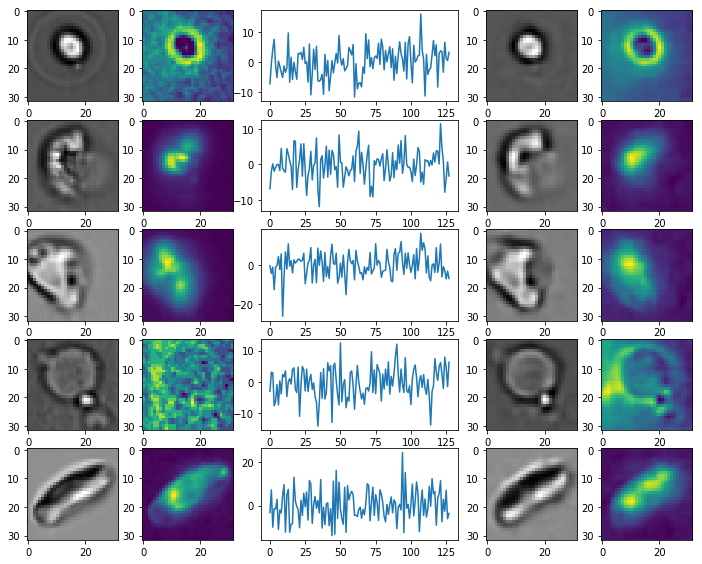

In [27]:
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,6,i*6 + 1)
    plt.imshow(vv[ix,:,:,0], cmap='gray')
    print(xhy[ix])
    plt.subplot(20,6,i*6 + 2)
    plt.imshow(vv[ix,:,:,1], cmap='viridis')
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,6,i*6 + 5)
    plt.imshow(xdd[ix,:,:,0], cmap='gray')
    plt.subplot(20,6,i*6 + 6)
    plt.imshow(xdd[ix,:,:,1], cmap='viridis')
   

In [31]:
mc = np.argmax(xhy, axis=1)

xhy.shape, mc.shape

((18000, 16), (18000,))

In [75]:
vvz = vv[(xhy > .9) & (mc == 0)]

print(vvz.shape)

vc1 = vvz[mc == 0]
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vc1),np.amax(vc1))
for i in range(20):
    ix = np.random.randint(0, len(vc1))
    #print(ix)
    plt.subplot(20,6,i*6 + 1)
    plt.imshow(vc1[ix,:,:,0], cmap='gray')
    plt.subplot(20,6,i*6 + 2)
    plt.imshow(vc1[ix,:,:,1], cmap='viridis')
    plt.subplot(20,3,i*3 + 2)
   

ValueError: operands could not be broadcast together with shapes (18000,16) (18000,) 

In [14]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
18000
hek (18000, 64)
0 0 (18000, 64) (18000, 64)


(18000, 64)

In [15]:
#from sklearn.preprocessing import normalize
#g_all = normalize(g_all, axis=1)

In [16]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 10


In [17]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=32, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(18000, 32)
[43.88242517 42.76152395 40.22306409 39.7163603  37.26961541 35.76731641
 34.23676657 33.11383648 32.2945104  31.90623989 31.09514601 30.95172328
 29.89213802 29.38873119 28.75701706 28.27375644 27.73810517 27.63879802
 27.4539771  27.19402451 26.92849771 26.51889391 26.25868761 26.01202101
 25.49930499 25.23882469 24.985095   24.72981713 24.21962113 24.00352341
 23.7853273  23.46435175]
(32, 64)


In [18]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 28
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)
gmm = BayesianGaussianMixture(nclust, covariance_type='full')
gmm.fit(g_all)
gm = gmm.predict(g_all)

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [19]:
order = ['ccb', 'ice', 'untreated']

In [20]:
df.head()

,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
0,28818,0,8818,0,fish3_untreated,28818,Fish3_Untreated.mm,0,0,0,32,32,untreated,fish3
1,130999,0,999,0,fish2_ice,130999,Fish2_ICE.mm,0,0,0,32,32,ice,fish2
2,59357,0,9357,0,fish1_ice,59357,Fish1_Ice.mm,0,0,0,32,32,ice,fish1
3,27313,0,7313,0,fish3_untreated,27313,Fish3_Untreated.mm,0,0,0,32,32,untreated,fish3
4,17678,0,7678,0,fish4_ice,17678,Fish4_ICE.mm,0,0,0,32,32,ice,fish4


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


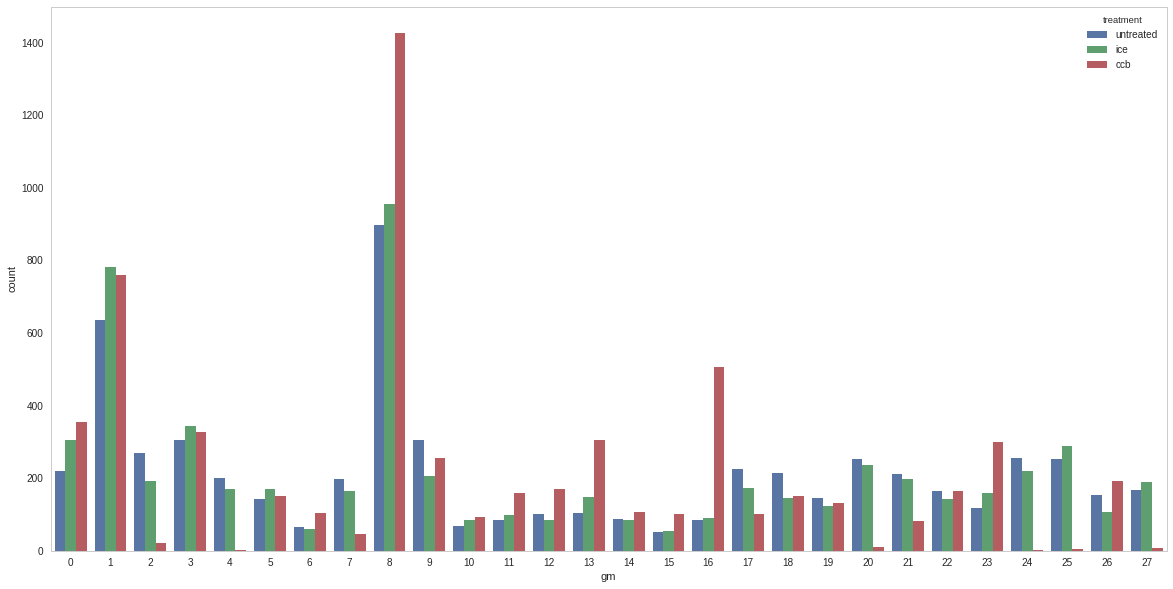

In [21]:
#km = gm
df['km'] = km
df['gm'] = gm
plt.figure(figsize=(20,10))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='gm', data=df, hue='treatment')

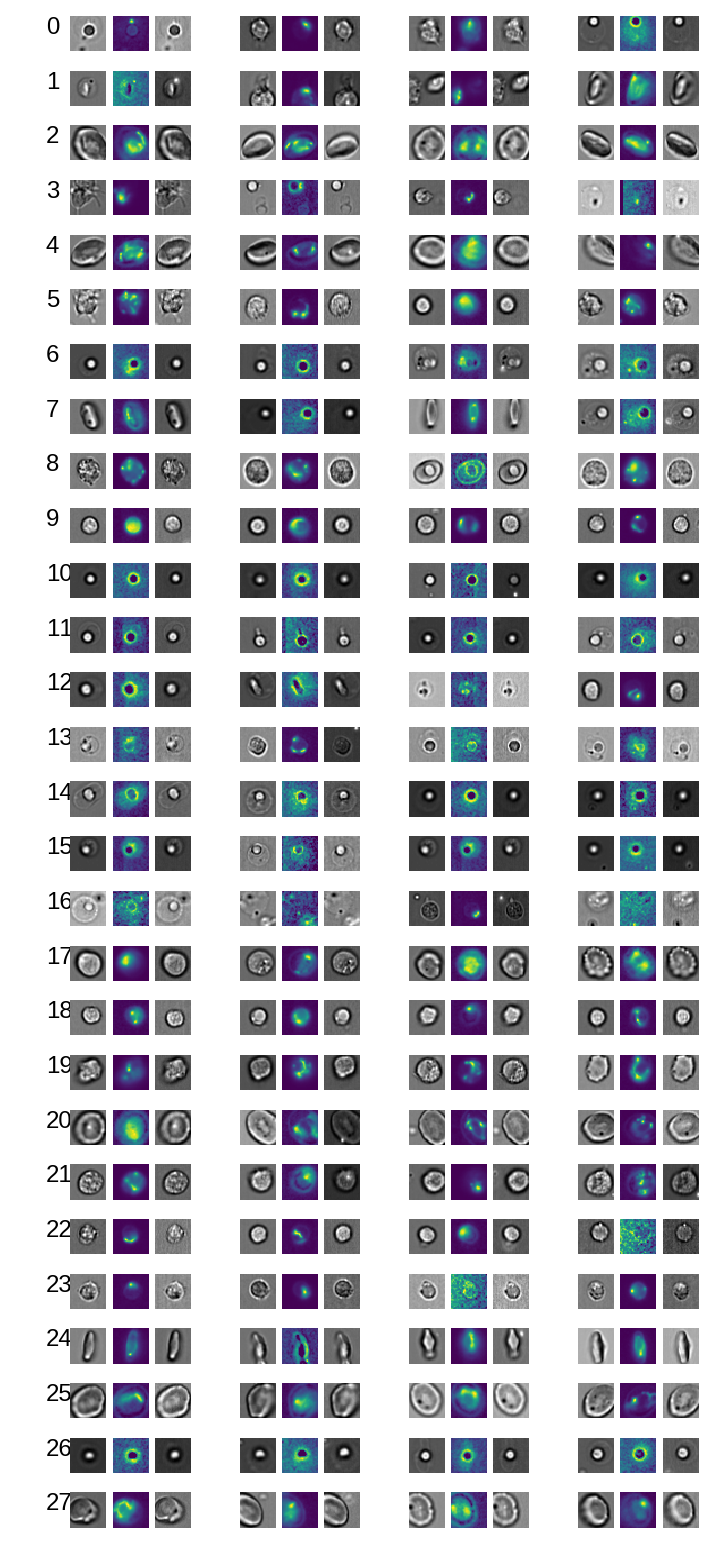

In [22]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['gm'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[gm == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
#    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 16, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 16, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='gray')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1
        if i < 3:
            counter += 1

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


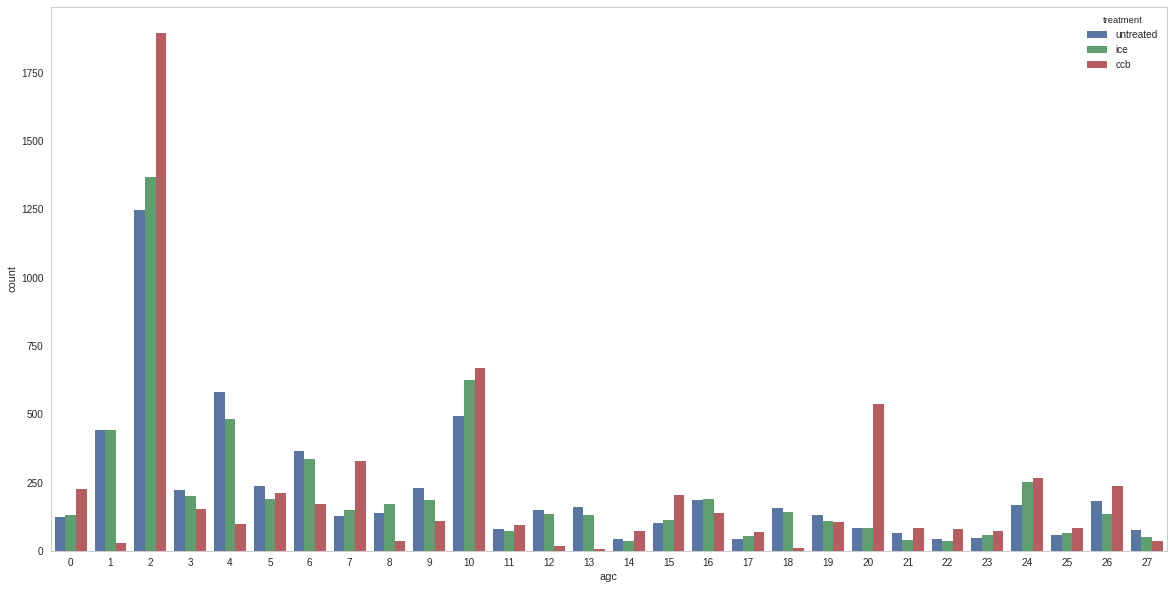

In [23]:
df['agc'] = agc
plt.figure(figsize=(20,10))
sns.countplot(x='agc', data=df, hue='treatment')
#plt.savefig('/media/cjw/Data/cyto/output/agc_filedist.png')

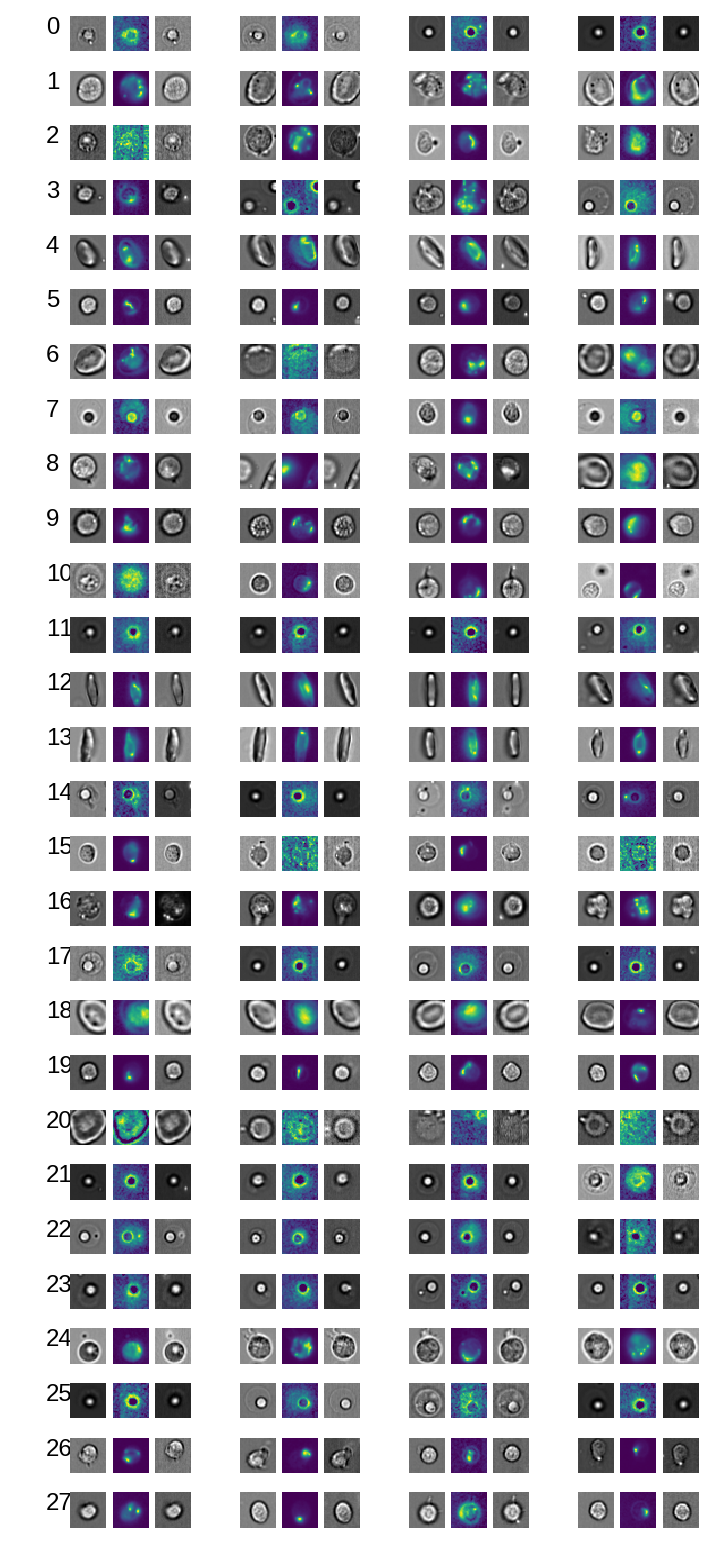

In [24]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
#    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 16, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 16, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='gray')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1
        if i < 3:
            counter += 1

-------------------------------------------------------------------------

(1, 64) (1, 64)
(1, 64)


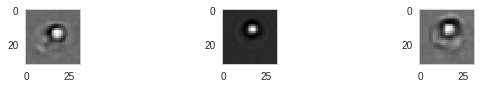

In [180]:
j = 170
im1 = vv[j:j + 1,:,:,:]
e1 = sess.run(encoder, feed_dict={images:vv[j:j + 1,:,:,:]})

#e2 = 0*e1 + 2 + np.random.normal(0, 1, (1,64))
print(e1.shape,e2.shape)
j = 167
im2 = vv[j:j + 1,:,:,:]
#im2[0,1:3,23:28,:] = 0
e2 = sess.run(encoder, feed_dict={images:im2})
e1[np.abs(e1) < 6] = 0
e2[np.abs(e2) < 6] = 0
print(e2.shape)
#fake[0,:,:,:]= vv[3]
#sz = 14 +0*tf.convert_to_tensor(samp)

xc1 = sess.run(decoder, feed_dict={encoder:e1})
plt.figure(figsize=(10,1))

plt.subplot(1, 3, 1)
plt.imshow(xc1[0, :,:, 0], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(im2[0, :,:, 0], cmap="gray")
e3 = (e2 + e1)/2
xc = sess.run(decoder, feed_dict={encoder:e2})
plt.subplot(1, 3, 3)
plt.imshow(xc[0, :,:,0], cmap="gray")


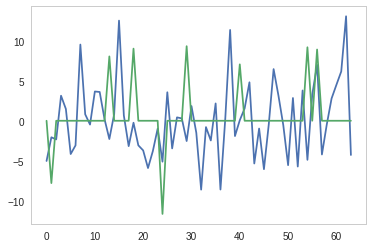

In [176]:
plt.plot(e1[0])
plt.plot(e2[0])
#plt.plot(e2[0] - e1[0])

In [92]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None, c=None, df=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[c == tn]
    g4 = g_all[c == tn]
    fig = plt.figure(figsize=(16,1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 2)
        plt.imshow(images4[ix,:,:,1], cmap='viridis')
        plt.axis('off')

        plt.subplot(nrows,8, i*8 + 3)
        plt.imshow(images4[ix,:,:,2], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 4)
        plt.imshow(images4[ix,:,:,3], cmap='afmhot')
        plt.axis('off')

        plt.subplot(nrows, 2, i*2 + 2)
        plt.plot(g4[ix]*0, color='gray')
        plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    
    if df is not None:
        ax = plt.subplot(2,2,2)
        plt.scatter(df['tsneX'], df['tsneY'], 16, gm, cmap='tab20c')
        xdf = df[df['gm'] == cluster_num]
        plt.scatter(xdf['tsneX'], xdf['tsneY'], label=cluster_num, s=24, color='yellow')
        ax.axis('equal')
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100, bbox_inches='tight', pad_inches=.1)
        plt.clf()
        plt.close(fig)
    
    plt.ion()



In [93]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/TalkOutput/gm_cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 10, outfile=outfile, c=gm)

NameError: name 'ximages' is not defined

In [94]:
display_cluster(12, 12, outfile=None, c=agc)

NameError: name 'ximages' is not defined

In [84]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=25).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(1696, 2)


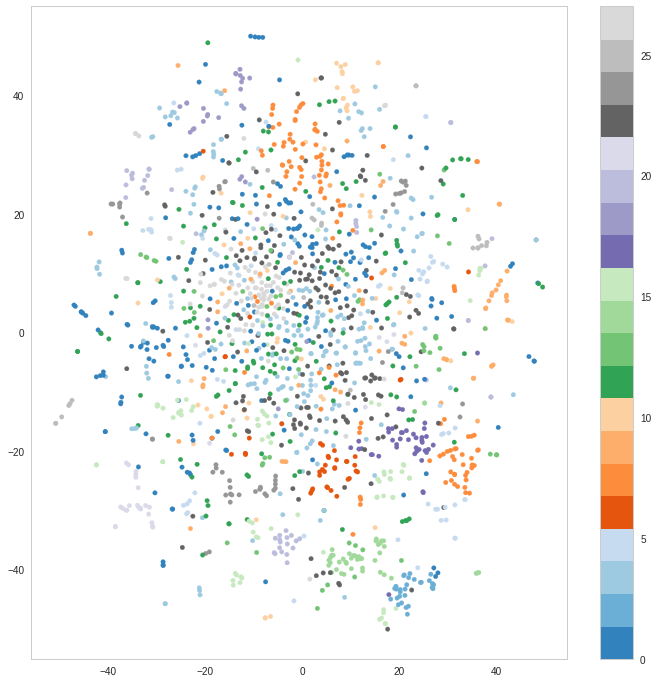

In [90]:
plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
plt.scatter(g_emb[:,0], g_emb[:,1], 20, agc, cmap='tab20c')
plt.colorbar()

# plt.subplot(4,1,2)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, gm1, cmap='tab20c')
# plt.colorbar()

# plt.subplot(2,1,2)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, agc, cmap='tab20c')
# plt.colorbar()

# plt.subplot(4,1,4)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, km, cmap='tab20c')
# plt.colorbar()

<class 'numpy.ndarray'>
0 31255
1 31256
2 31257
3 31258
4 31259
5 31260
6 31261
7 31262
8 31263
9 31264
10 31265
11 31266
12 31267
13 31268
14 31269
15 31270
16 31271
17 31272
18 31273
19 31274
20 31275
21 31276
22 31277
23 31278
24 31279
25 31280
26 31281
27 31282


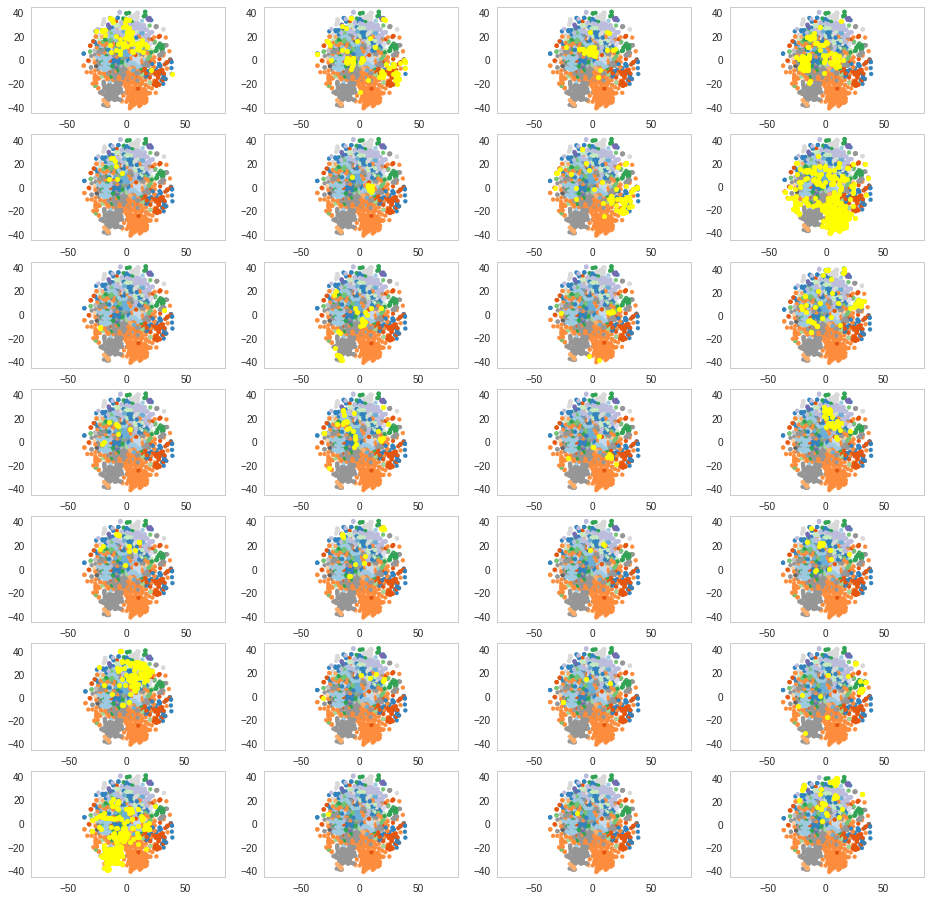

In [64]:

df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]
#df['gm'] = gm

#plt.ioff()
print(type(cly))
plt.figure(figsize=(16,16))
for index, i in enumerate(np.unique(cly)): #range(nclust):
#         plt.figure(figsize=(16,16))
        #ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color=gm, figsize=(6,6))
        print(index, i)
        ax = plt.subplot(7,4, index + 1)
        ax.scatter(df['tsneX'], df['tsneY'], 16, cly, cmap='tab20c')
        xdf = df[df['clusterId_y'] == i]
        ax.scatter(xdf['tsneX'], xdf['tsneY'], label=i, s=24, color='yellow')
        ax.axis('equal')
        outfile = "/media/cjw/Data/cyto/TalkOutput/tsne_gm_" + str(i).zfill(3) + ".png"
        #break
        #plt.savefig(outfile, dpi=100, bbox_inches='tight', pad_inches=.1)
        #plt.clf()
        #plt.close()
#plt.ion()

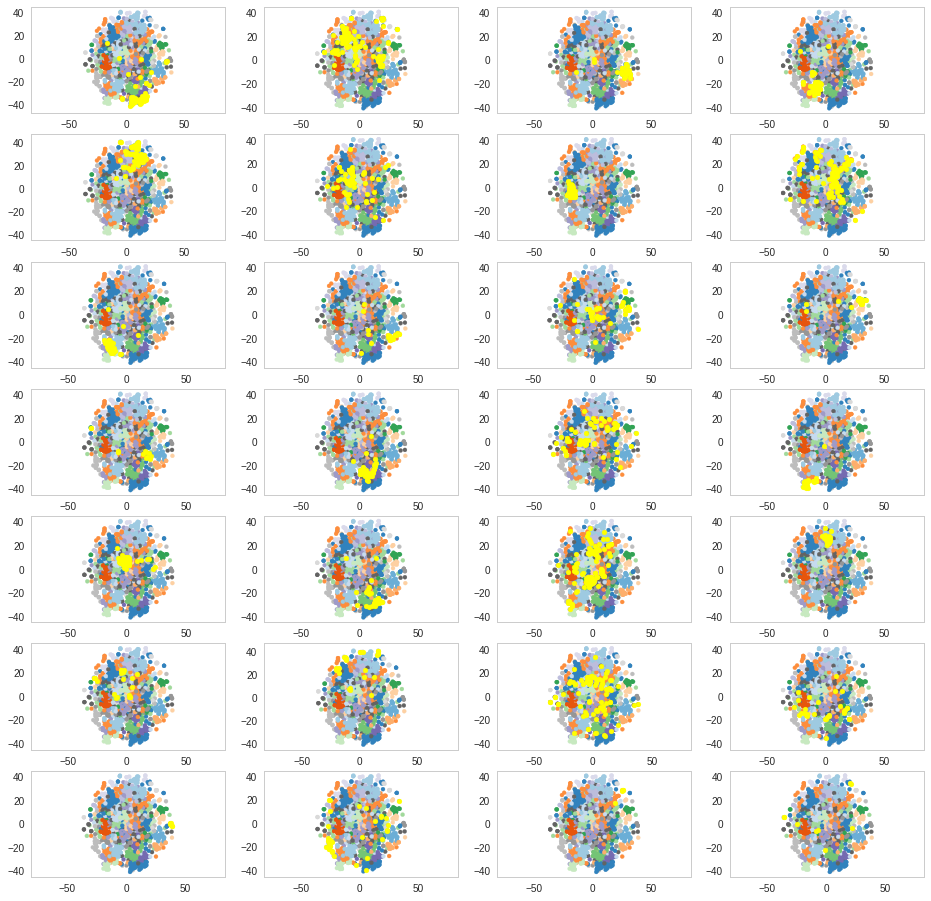

In [75]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]
#df['gm'] = gm

#plt.ioff()

plt.figure(figsize=(16,16))
for i in range(nclust):
#         plt.figure(figsize=(16,16))
        #ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color=gm, figsize=(6,6))
        ax = plt.subplot(7,4, i + 1)
        ax.scatter(df['tsneX'], df['tsneY'], 16, agc, cmap='tab20c')
        xdf = df[df['agc'] == i]
        ax.scatter(xdf['tsneX'], xdf['tsneY'], label=i, s=24, color='yellow')
        ax.axis('equal')
        outfile = "/media/cjw/Data/cyto/TalkOutput/tsne_gm_" + str(i).zfill(3) + ".png"
        #break
        #plt.savefig(outfile, dpi=100, bbox_inches='tight', pad_inches=.1)
        #plt.clf()
        #plt.close()
#plt.ion()


In [92]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/TalkOutput/tsne_gm_cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 10, outfile=outfile, c=gm, df=df)
    

In [111]:
alldf.head()

,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run,cid,clusterId_x,clusterId_y
0,0,0,0,fish3_ccb,0,Fish3_CCB.mm,0,0,0,32,32,ccb,fish3,0,26874,31279
1,0,1,0,fish3_ccb,1,Fish3_CCB.mm,0,0,0,32,32,ccb,fish3,1,26874,31275
2,0,2,0,fish3_ccb,2,Fish3_CCB.mm,0,0,0,32,32,ccb,fish3,2,26855,31260
3,0,3,0,fish3_ccb,3,Fish3_CCB.mm,0,0,0,32,32,ccb,fish3,3,26874,31255
4,0,4,0,fish3_ccb,4,Fish3_CCB.mm,0,0,0,32,32,ccb,fish3,4,26851,31271


[ 8987.  9716.  7001. 15789.   956.  1713.  9759. 32481.   288.  3412.
  1724.  9140.  1989.  3953.  1033.  2806.  1271.  1768.   627.  2780.
 13226.  1062.   305.  4072. 28742.   173.   112.  4714.] (28,)
[1.79309657 1.65915301 1.65664931 4.30452563 3.12418301 4.74515235
 1.99570552 1.81003065 3.46987952 3.08499096 1.76820513 3.5385211
 4.0509165  1.76709879 2.56327543 1.75594493 3.2757732  2.09976247
 2.91627907 1.82414698 3.76166098 2.19875776 3.38888889 3.26805778
 1.99154656 3.14545455 2.43478261 4.00509771] (28,)
[2.79378823 1.96169984 5.72090288 1.24642378 0.95137538 1.20975849
 2.18462257 5.47568389 0.07833712 1.36819707 2.31076332 0.75463879
 0.27075499 0.42346371 0.71198787 2.65106093 5.96458181 4.18306323
 2.9422903  0.74710368 0.17919894 7.53494638 9.31662552 5.11939841
 1.50381934 9.79305048] (26,)
[2.77413067 4.01445451 2.27306704 6.48092829 0.47136684 0.68338467
 4.87906965 7.12611226 0.14423302 0.95598782 0.33635811 5.03482341
 0.86414351 0.98194154 0.62559956 0.6937820

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5]), <a list of 26 Text yticklabel objects>)

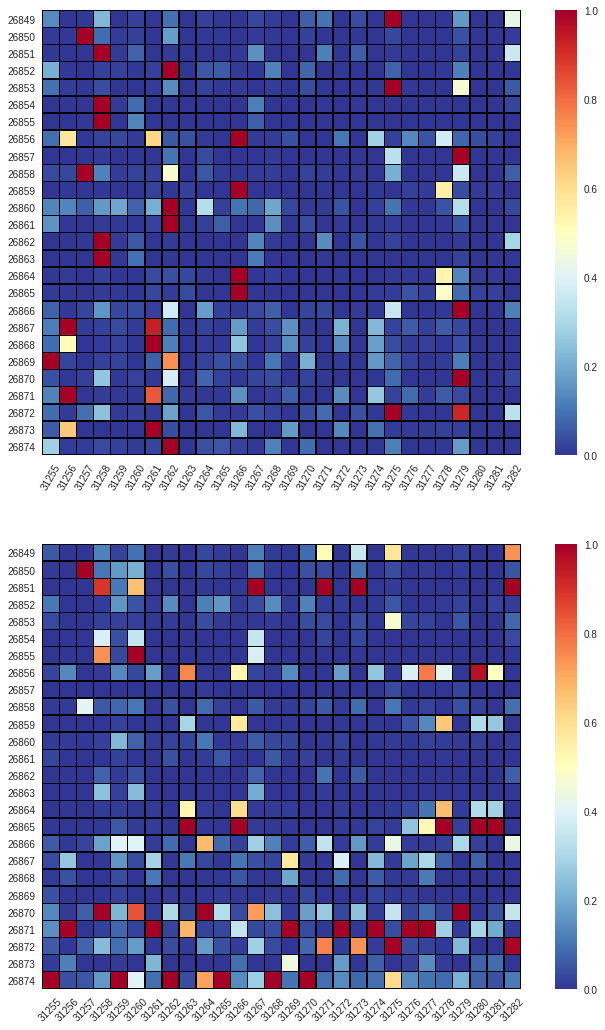

In [245]:
%matplotlib inline
from sklearn.preprocessing import normalize
p_df = pd.pivot_table(alldf, values='xc', index=['clusterId_x'], columns=['clusterId_y'], aggfunc='count')
p_df = p_df.fillna(0)
plt.figure(figsize=(12,18))
v = p_df.values
v0 = normalize(v, axis=0, norm='max')
print(np.sum(v, axis=0), np.sum(v, axis=0).shape)
print(np.sum(v0, axis=0), np.sum(v0, axis=0).shape)
print(np.sum(v0, axis=1), np.sum(v0, axis=1).shape)
v1 = normalize(v, axis=1, norm='max')
print(np.sum(v1, axis=0), np.sum(v1, axis=0).shape)
print(np.sum(v1, axis=1), np.sum(v1, axis=1).shape)
plt.subplot(2,1,1)
sns.heatmap(v1, square=True, xticklabels=p_df.columns, yticklabels=p_df.index, cmap="RdYlBu_r",
           linewidth=.5, linecolor='black', robust=True)
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.subplot(2,1,2)
sns.heatmap(v0, square=True, xticklabels=p_df.columns, yticklabels=p_df.index, cmap="RdYlBu_r",
           linewidth=.5, linecolor='black', robust=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)


169599.0

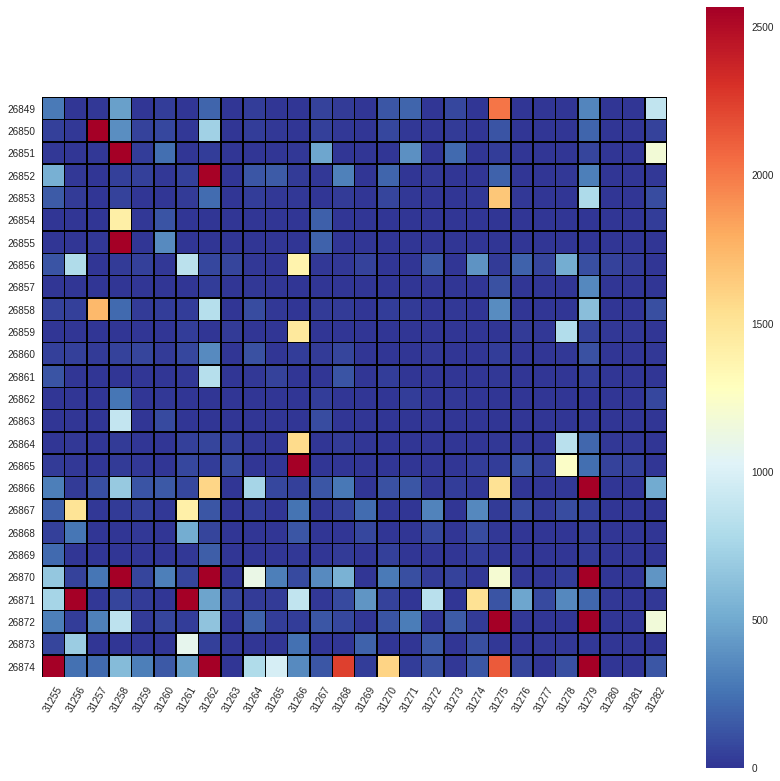

In [263]:
plt.figure(figsize=(14,14))

sns.heatmap(v, square=True, xticklabels=p_df.columns, yticklabels=p_df.index, cmap="RdYlBu_r",
           linewidth=.5, linecolor='black', robust=True)
plt.xticks(rotation=60)
plt.yticks(rotation=0)
np.sum(v)

In [39]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, cdist

dm =  np.arccos(1 -cdist(g_all,g_all, metric='cosine'))
#dm =  cdist(g_all, g_all, metric='euclidean')
#dm = distance_matrix(mma, mma)
print(dm.shape)

ddict = dict()
for i in range(g_all.shape[0]):
    ri = np.argsort(dm[i])
    ddict[i] = ri[1:13]

dm[1,ddict[1]]

(4500, 4500)


array([0.84650457, 0.89392709, 0.92158811, 0.95054435, 0.95505369,
       0.96474147, 0.98575274, 0.99417142, 1.00281157, 1.01690594,
       1.0258913 , 1.0268415 ])

In [41]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score

sc = silhouette_score(dm, labels=gm, metric='precomputed', sample_size=None)
ch = calinski_harabaz_score(g_all, gm)
sc, ch

(0.02651123624465178, 33.53769632381485)

In [93]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors